In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.formula.api import ols

In [2]:
# load data
data = pd.read_csv('./all_params_168_w_utility.csv')

In [3]:
data.head()

,Unnamed: 0,model,threshold,n_hosp_mode,n_prescription_mode,avg_max_unfairness_risk,avg_mean_unfairness_risk,initial_unfairness_risk,avg_max_gap_tpr,avg_mean_gap_tpr,...,initial_gap_f1,avg_max_gap_accuracy,avg_mean_gap_accuracy,initial_gap_accuracy,avg_utility_tpr,avg_utility_fpr,avg_utility_precision,avg_utility_f1,avg_utility_accuracy,n_traces
0,0,xgboost,0.30,expectation,expectation,0.034326,0.018609,0.001172,0.116718,0.083542,...,0.041287,0.043808,0.026334,0.000011,0.754151,0.221015,0.081843,0.145820,0.778414,10
1,1,xgboost,0.40,expectation,expectation,0.034190,0.018479,0.001172,0.129267,0.103000,...,0.019108,0.041355,0.021947,0.005875,0.671434,0.145982,0.111901,0.187242,0.849820,10
2,2,xgboost,0.45,expectation,expectation,0.034062,0.018439,0.001172,0.141259,0.113732,...,0.000482,0.035838,0.018203,0.008449,0.632535,0.114534,0.133111,0.213616,0.879651,10
3,3,xgboost,0.50,expectation,expectation,0.034036,0.018372,0.001172,0.158405,0.130731,...,0.023762,0.036618,0.017988,0.008983,0.584133,0.088984,0.155823,0.237894,0.903502,10
4,4,xgboost,0.55,expectation,expectation,0.034154,0.018201,0.001172,0.179215,0.150646,...,0.022847,0.038856,0.017284,0.007927,0.533025,0.065802,0.184935,0.265255,0.924976,10


In [4]:
data.columns

Index(['Unnamed: 0', 'model', 'threshold', 'n_hosp_mode',
       'n_prescription_mode', 'avg_max_unfairness_risk',
       'avg_mean_unfairness_risk', 'initial_unfairness_risk',
       'avg_max_gap_tpr', 'avg_mean_gap_tpr', 'initial_gap_tpr',
       'avg_max_gap_fpr', 'avg_mean_gap_fpr', 'initial_gap_fpr',
       'avg_max_gap_precision', 'avg_mean_gap_precision',
       'initial_gap_precision', 'avg_max_gap_f1', 'avg_mean_gap_f1',
       'initial_gap_f1', 'avg_max_gap_accuracy', 'avg_mean_gap_accuracy',
       'initial_gap_accuracy', 'avg_utility_tpr', 'avg_utility_fpr',
       'avg_utility_precision', 'avg_utility_f1', 'avg_utility_accuracy',
       'n_traces'],
      dtype='object')

In [5]:
data['max_increase_unfairness_risk'] = data['avg_max_unfairness_risk'] - data['initial_unfairness_risk']
data['avg_increase_unfairness_risk'] = data['avg_mean_unfairness_risk'] - data['initial_unfairness_risk']
data['avg_increase_gap_tpr'] = data['avg_mean_gap_tpr'] - data['initial_gap_tpr']
data['avg_increase_gap_fpr'] = data['avg_mean_gap_fpr'] - data['initial_gap_fpr']
data['avg_increase_gap_precision'] = data['avg_mean_gap_precision'] - data['initial_gap_precision']
data['avg_increase_gap_f1'] = data['avg_mean_gap_f1'] - data['initial_gap_f1']
data['avg_increase_gap_accuracy'] = data['avg_mean_gap_accuracy'] - data['initial_gap_accuracy']

In [6]:
lm = ols('max_increase_unfairness_risk ~ (model + scale(threshold) + n_hosp_mode + n_prescription_mode)**2', data=data).fit()

In [22]:
# get the anova table
table = sm.stats.anova_lm(lm, typ=2)
table['eta_sq'] = table['sum_sq'] / table['sum_sq'].sum()
# remove residuals
table = table.iloc[:-1]

# get the ranking of the features based on sum of squares of anova table
table['sum_sq_rank'] = table['sum_sq'].rank(ascending=False)

# identify all variables p<=0.05
statistically_significant_variables = table[table['PR(>F)'] <= 0.05].index

In [8]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     max_increase_unfairness_risk   R-squared:                       0.995
Model:                                      OLS   Adj. R-squared:                  0.994
Method:                           Least Squares   F-statistic:                     1191.
Date:                          Tue, 12 Nov 2024   Prob (F-statistic):          3.04e-152
Time:                                  19:57:16   Log-Likelihood:                 1059.7
No. Observations:                           168   AIC:                            -2069.
Df Residuals:                               143   BIC:                            -1991.
Df Model:                                    24                                         
Covariance Type:                      nonrobust                                         
===========================================================================================================================
                                                              coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------
Intercept                                                   0.0214      0.000    136.691      0.000       0.021       0.022
model[T.xgboost]                                            0.0112      0.000     61.980      0.000       0.011       0.012
n_hosp_mode[T.random_1]                                     0.0003      0.000      1.438      0.153      -0.000       0.001
n_hosp_mode[T.random_2]                                  5.716e-05      0.000      0.274      0.784      -0.000       0.000
n_hosp_mode[T.same]                                        -0.0003      0.000     -1.455      0.148      -0.001       0.000
n_prescription_mode[T.random_1]                            -0.0024      0.000    -11.735      0.000      -0.003      -0.002
n_prescription_mode[T.random_2]                            -0.0024      0.000    -11.798      0.000      -0.003      -0.002
model[T.xgboost]:n_hosp_mode[T.random_1]                   -0.0004      0.000     -1.989      0.049      -0.001   -2.57e-06
model[T.xgboost]:n_hosp_mode[T.random_2]                   -0.0003      0.000     -1.538      0.126      -0.001    9.15e-05
model[T.xgboost]:n_hosp_mode[T.same]                       -0.0018      0.000     -8.473      0.000      -0.002      -0.001
model[T.xgboost]:n_prescription_mode[T.random_1]            0.0025      0.000     14.018      0.000       0.002       0.003
model[T.xgboost]:n_prescription_mode[T.random_2]            0.0027      0.000     14.697      0.000       0.002       0.003
n_hosp_mode[T.random_1]:n_prescription_mode[T.random_1]     0.0001      0.000      0.432      0.666      -0.000       0.001
n_hosp_mode[T.random_2]:n_prescription_mode[T.random_1]     0.0003      0.000      1.228      0.221      -0.000       0.001
n_hosp_mode[T.same]:n_prescription_mode[T.random_1]         0.0002      0.000      0.929      0.355      -0.000       0.001
n_hosp_mode[T.random_1]:n_prescription_mode[T.random_2]  4.504e-05      0.000      0.176      0.860      -0.000       0.001
n_hosp_mode[T.random_2]:n_prescription_mode[T.random_2]    -0.0002      0.000     -0.815      0.417      -0.001       0.000
n_hosp_mode[T.same]:n_prescription_mode[T.random_2]      9.537e-05      0.000      0.373      0.709      -0.000       0.001
scale(threshold)                                        -6.074e-05   9.75e-05     -0.623      0.534      -0.000       0.000
model[T.xgboost]:scale(threshold)                          -0.0005   7.37e-05     -6.432      0.000      -0.001      -0.000
scale(threshold):n_hosp_mode[T.random_1]                 5.967e-05      0.000      0.572      0.568      -0.000       0.0

In [9]:
table

,sum_sq,df,F,PR(>F),eta_sq,sum_sq_rank
model,6.349890e-03,1.0,27815.790271,1.011751e-165,0.967987,1.0
n_hosp_mode,3.919683e-05,3.0,57.234102,2.288067e-24,0.005975,3.0
n_prescription_mode,3.822310e-05,2.0,83.718449,8.519875e-25,0.005827,4.0
model:n_hosp_mode,1.922774e-05,3.0,28.075811,2.460103e-14,0.002931,5.0
model:n_prescription_mode,6.284841e-05,2.0,137.654204,4.672186e-34,0.009581,2.0
n_hosp_mode:n_prescription_mode,1.281275e-06,6.0,0.935441,4.716381e-01,0.000195,9.0
scale(threshold),5.506362e-06,1.0,24.120703,2.440331e-06,0.000839,7.0
model:scale(threshold),9.444116e-06,1.0,41.370098,1.769562e-09,0.001440,6.0
scale(threshold):n_hosp_mode,1.536210e-06,3.0,2.243131,8.585063e-02,0.000234,8.0
scale(threshold):n_prescription_mode,9.595079e-08,2.0,0.210157,8.107069e-01,0.000015,10.0


### Get sampling configuration of 2-coverage and 3-coverage

In [10]:
from covertable import make, sorters, criteria
X = data[['model', 'threshold', 'n_hosp_mode', 'n_prescription_mode']]
model_unique = X['model'].unique()
threshold_unique = X['threshold'].unique()
n_hosp_mode_unique = X['n_hosp_mode'].unique()
n_prescription_mode_unique = X['n_prescription_mode'].unique()

sample_2 = make([model_unique, threshold_unique, n_hosp_mode_unique, n_prescription_mode_unique], length=2)
sample_2 = [tuple(x) for x in sample_2]
sample_3 = make([model_unique, threshold_unique, n_hosp_mode_unique, n_prescription_mode_unique], length=3)
sample_3 = [tuple(x) for x in sample_3]
print(len(sample_2), len(sample_3), len(data))

28 85 168


In [11]:
sample_data_2 = data[data[['model', 'threshold', 'n_hosp_mode', 'n_prescription_mode']].apply(tuple, 1).isin(sample_2)]
sample_data_3 = data[data[['model', 'threshold', 'n_hosp_mode', 'n_prescription_mode']].apply(tuple, 1).isin(sample_3)]

## Fit regression model for sampled data

In [12]:
# fit lm for 2-coverage sampling
lm_2 = ols('max_increase_unfairness_risk ~ (model + scale(threshold) + n_hosp_mode + n_prescription_mode)**2', data=sample_data_2).fit()
# fit lm for 3-coverage sampling
lm_3 = ols('max_increase_unfairness_risk ~ (model + scale(threshold) + n_hosp_mode + n_prescription_mode)**2', data=sample_data_3).fit()

In [13]:
# compute the MSE for original lm
mse = np.mean((lm.predict(data) - data['max_increase_unfairness_risk'])**2)
# compute the MSE for 2-coverage sampling lm
mse_2 = np.mean((lm_2.predict(data) - data['max_increase_unfairness_risk'])**2)
# compute the MSE for 3-coverage sampling lm
mse_3 = np.mean((lm_3.predict(data) - data['max_increase_unfairness_risk'])**2)

print(mse, mse_2, mse_3)

1.9431285879858024e-07 9.403758696489481e-07 2.3288756970188934e-07


In [14]:
from sklearn.metrics import r2_score
# compute the R2 for 3 lm
r2 = r2_score(data['max_increase_unfairness_risk'], lm.predict(data))
r2_2 = r2_score(data['max_increase_unfairness_risk'], lm_2.predict(data))
r2_3 = r2_score(data['max_increase_unfairness_risk'], lm_3.predict(data))

print(r2, r2_2, r2_3)

0.9950236149428262 0.9759168155170903 0.994035710096431


In [24]:
# get the anova table for 2-coverage sampling and 3-coverage sampling
table_2 = sm.stats.anova_lm(lm_2, typ=2)
table_3 = sm.stats.anova_lm(lm_3, typ=2)

# remove residuals
table_2 = table_2.iloc[:-1]
table_3 = table_3.iloc[:-1]

# get the ranking of the features based on sum of squares of anova table
table_2['sum_sq_rank'] = table_2['sum_sq'].rank(ascending=False)
table_3['sum_sq_rank'] = table_3['sum_sq'].rank(ascending=False)

## Compare the feature ranking between baseline and sampling

In [49]:
# compute Kendall Tau for significant variables
from scipy.stats import kendalltau
print(kendalltau(table.loc[statistically_significant_variables]['sum_sq_rank'], table_2.loc[statistically_significant_variables]['sum_sq_rank']))
print(kendalltau(table.loc[statistically_significant_variables]['sum_sq_rank'], table_3.loc[statistically_significant_variables]['sum_sq_rank']))

KendalltauResult(correlation=0.6190476190476191, pvalue=0.06904761904761905)
KendalltauResult(correlation=0.7142857142857143, pvalue=0.03015873015873016)


In [50]:
# compute Rank Biased Overlap
from rbo import rbo
# get the ranked features based on sum_sq_rank for statistically significant variables
ranked_features_gt_sig = table.loc[statistically_significant_variables].sort_values(by=['sum_sq_rank']).index.to_list()
ranked_features_2_sig = table_2.loc[statistically_significant_variables].sort_values(by=['sum_sq_rank']).index.to_list()
ranked_features_3_sig = table_3.loc[statistically_significant_variables].sort_values(by=['sum_sq_rank']).index.to_list()

# compute Rank Biased Overlap
print(rbo.RankingSimilarity(ranked_features_gt_sig, ranked_features_2_sig).rbo_ext(p=0.8))
print(rbo.RankingSimilarity(ranked_features_gt_sig, ranked_features_3_sig).rbo_ext(p=0.8))

0.8670933333333334
0.8834773333333333


## Trade-off Analysis

In [22]:
# draw the trade-off plot for data columns [avg_mean_unfairness_risk, avg_utility_accuracy]
# highlight the data points

# Adjusting the Pareto efficiency function for the new criteria
def is_pareto_efficient_minimize_cost(costs, returns):
    """
    Identify the Pareto efficient points for minimizing costs and maximizing returns
    :param costs: An array of costs to minimize
    :param returns: An array of returns to maximize
    :return: A boolean array, where True indicates Pareto efficiency
    """
    is_efficient = np.ones(costs.shape[0], dtype=bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.logical_not(np.logical_and(returns[is_efficient] <= returns[i], costs[is_efficient] >= c))
            is_efficient[i] = True  # And keep self
    return is_efficient

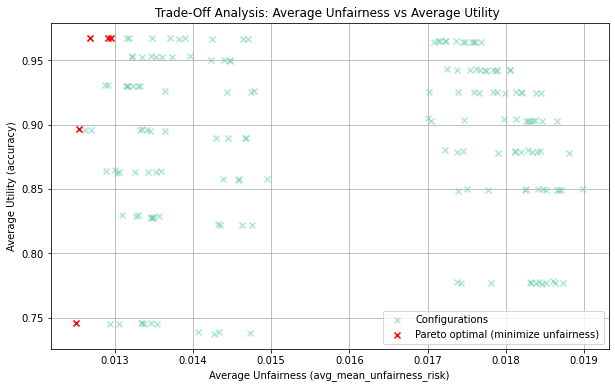

In [23]:
pareto_minimize_cost = is_pareto_efficient_minimize_cost(data['avg_mean_unfairness_risk'].values, data['avg_utility_accuracy'].values)

# Re-plotting the data with updated Pareto optimal points
plt.figure(figsize=(10, 6))
plt.scatter(data['avg_mean_unfairness_risk'], data['avg_utility_accuracy'], alpha=0.5, label='Configurations', marker='x', color='mediumaquamarine')
plt.scatter(data['avg_mean_unfairness_risk'][pareto_minimize_cost], data['avg_utility_accuracy'][pareto_minimize_cost], color='r', marker='x', label='Pareto optimal (minimize unfairness)')
plt.title('Trade-Off Analysis: Average Unfairness vs Average Utility ')
plt.xlabel('Average Unfairness (avg_mean_unfairness_risk)')
plt.ylabel('Average Utility (accuracy)')
plt.grid()
plt.legend()

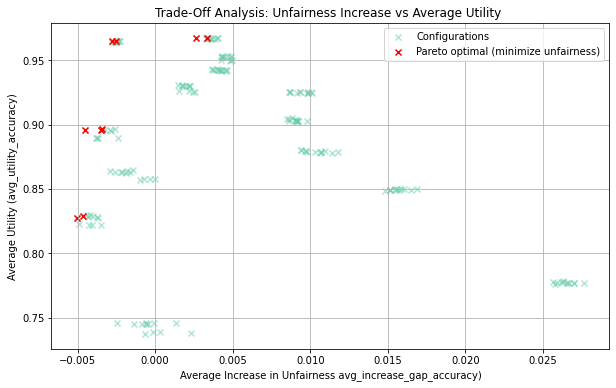

In [24]:
pareto_minimize_cost = is_pareto_efficient_minimize_cost(data['avg_increase_gap_accuracy'].values, data['avg_utility_accuracy'].values)

# Re-plotting the data with updated Pareto optimal points
plt.figure(figsize=(10, 6))
plt.scatter(data['avg_increase_gap_accuracy'], data['avg_utility_accuracy'], alpha=0.5, label='Configurations', marker='x', color='mediumaquamarine')
plt.scatter(data['avg_increase_gap_accuracy'][pareto_minimize_cost], data['avg_utility_accuracy'][pareto_minimize_cost], color='r', marker='x', label='Pareto optimal (minimize unfairness)')
plt.title('Trade-Off Analysis: Unfairness Increase vs Average Utility ')
plt.xlabel('Average Increase in Unfairness avg_increase_gap_accuracy)')
plt.ylabel('Average Utility (avg_utility_accuracy)')
plt.grid()
plt.legend()

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from math import pi
from sklearn.preprocessing import MinMaxScaler

def plot_spider_chart(df, features, path=None):
    # Number of variables we're plotting.
    num_vars = len(features)

    # Compute angle each bar is centered on:
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # The plot is circular, so we need to "complete the loop" and append the start to the end.
    angles += angles[:1]

    sns.set_context('paper', font_scale=1.4)

    # Initialize the spider plot
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

    # Draw one axe per variable and add labels
    plt.xticks(angles[:-1], features, size=20)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0.25, 0.5, 0.75], ["0.25", "0.5", "0.75"], color="grey", size=15)
    plt.ylim(0, 1)

    line_styles = ['solid', (0, (5, 10)),'dotted', (5, (10, 3)), 'dashdot']  # List of line styles

    i = 0
    for idx, row in df.iterrows():
        values = row.values.flatten().tolist()
        values += values[:1]
        line_style = line_styles[i % len(line_styles)]  # Get the line style based on the index
        ax.plot(angles, values, linewidth=1, linestyle=line_style, label=f'Config {idx}')
        ax.fill(angles, values, alpha=0.1)
        i += 1


    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

    if path:
        plt.savefig(path, format="pdf", bbox_inches="tight")


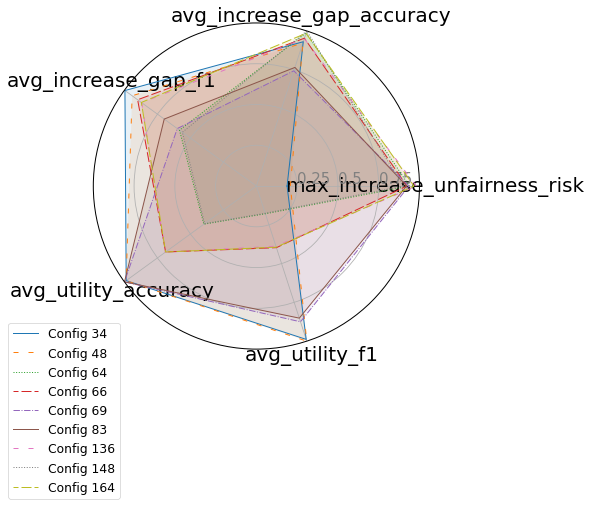

In [28]:
scaler = MinMaxScaler()
features = ['max_increase_unfairness_risk', 'avg_increase_gap_accuracy', 
            'avg_increase_gap_f1', 'avg_utility_accuracy', 'avg_utility_f1']
df_normalized = pd.DataFrame(scaler.fit_transform(data[features]), 
                             columns=features)
for f in features[:3]:
    df_normalized[f] = 1 - df_normalized[f]

pareto_data_features = df_normalized[pareto_minimize_cost][features]
plot_spider_chart(pareto_data_features, features, 'radar_new.pdf')

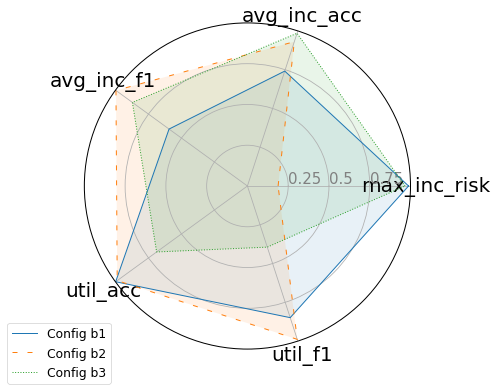

In [29]:
three_pareto_index = [167, 34, 164]
scaler = MinMaxScaler()
features = ['max_increase_unfairness_risk', 'avg_increase_gap_accuracy', 
            'avg_increase_gap_f1', 'avg_utility_accuracy', 'avg_utility_f1']
df_normalized = pd.DataFrame(scaler.fit_transform(data[features]), 
                             columns=features)
for f in features[:3]:
    df_normalized[f] = 1 - df_normalized[f]
new_features = ['max_inc_risk', 'avg_inc_acc', 
            'avg_inc_f1', 'util_acc', 'util_f1']
pareto_data_features = df_normalized.loc[three_pareto_index][features]
pareto_data_features.index = ['b1', 'b2', 'b3']
plot_spider_chart(pareto_data_features, new_features, 'radar_new.pdf')

In [77]:
data.loc[three_pareto_index]

,Unnamed: 0,model,threshold,n_hosp_mode,n_prescription_mode,avg_max_unfairness_risk,avg_mean_unfairness_risk,initial_unfairness_risk,avg_max_gap_tpr,avg_mean_gap_tpr,...,avg_utility_f1,avg_utility_accuracy,n_traces,max_increase_unfairness_risk,avg_increase_unfairness_risk,avg_increase_gap_tpr,avg_increase_gap_fpr,avg_increase_gap_precision,avg_increase_gap_f1,avg_increase_gap_accuracy
167,167,mlp,0.7,random_2,random_2,0.021968,0.012687,0.003897,0.099798,0.074379,...,0.323921,0.967201,11,0.018070,0.008789,0.012477,0.003896,-0.012403,-0.003270,0.003425
34,34,xgboost,0.7,random_1,expectation,0.031958,0.017156,0.001172,0.186726,0.152134,...,0.356024,0.964470,10,0.030786,0.015984,0.006188,0.004225,0.024690,-0.038397,-0.002777
164,164,mlp,0.5,random_2,random_2,0.022309,0.012623,0.003897,0.119917,0.090048,...,0.219629,0.895704,10,0.018412,0.008726,-0.011998,-0.002745,-0.013317,-0.027527,-0.004548
